### Importing the modules.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configure matplotlib and seaborn
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, pos_tag, ne_chunk
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer

# Sklearn vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# BeautifulSoup
from bs4 import BeautifulSoup

# Regex
import re

# Model selection
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV

# Evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

# Preprocessing (sklearn)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Stop words and lemmatizer (instantiate once to reuse inside clean function)
stop_words = set(stopwords.words('english'))
le = WordNetLemmatizer()

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, ReLU, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Note: CuDNNLSTM is deprecated in TF 2.x, use LSTM with default settings

# Gensim Word2Vec
from gensim.models import FastText
import gensim, multiprocessing

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\itn.heydar.alvaro\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itn.heydar.alvaro\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\itn.heydar.alvaro\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\itn.heydar.alvaro\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


True

### LOADING THE DATASET

In [3]:
rev_frame=pd.read_csv(r'Reviews.csv')
df=rev_frame.copy()

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### A brief description of the dataset from Overview tab on Kaggle : -

The data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

### DATA CLEANING AND PRE-PROCESSING

#### Since here I am concerned with sentiment analysis I shall keep only the 'Text' and the 'Score' column.

In [5]:
df=df[['Text','Score']]

In [6]:
df['review']=df['Text']
df['rating']=df['Score']
df.drop(['Text','Score'],axis=1,inplace=True)


In [7]:
print(df.shape)
df.head()

(568454, 2)


,review,rating
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


#### Let us now see if any of the column has any null values.

In [8]:
# check for null values
df['review'].isnull().sum()  # no null values.

0

In [9]:
df['rating'].isnull().sum()

0

#### Note that there is no point for keeping rows with different scores or sentiment for same review text.  So I will keep only one instance and drop the rest of the duplicates.

In [10]:
# remove duplicates/ for every duplicate we will keep only one row of that type. 
df.drop_duplicates(subset=['rating','review'],keep='first',inplace=True) 

In [11]:
# now check the shape. note that shape is reduced which shows that we did had duplicate rows.
print(df.shape)
df.head()

(393675, 2)


,review,rating
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


#### Let us now print some reviews and see if we can get insights from the text.

In [12]:
# printing some reviews to see insights.
for review in df['review'][:5]:
    print(review+'\n'+'\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


If you are looking for the se

#### Note that since we are doing sentiment analysis I will convert the values in score column to sentiment. Sentiment is 0 for ratings or scores less than 3 and 1 or  +  elsewhere. This therefore becomes a binary classification task in NLP domain.

In [13]:
def mark_sentiment(rating):
    if(rating<=3):
        return 0
    else:
        return 1

In [14]:
df['sentiment']=df['rating'].apply(mark_sentiment)

In [15]:
df.drop(['rating'],axis=1,inplace=True)

In [16]:
df.head()

,review,sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [17]:
df['sentiment'].value_counts()

sentiment
1    306819
0     86856
Name: count, dtype: int64

#### Pre-processing steps :

1 ) First **removing punctuation and html tags** if any. note that the html tas may be present ast the data must be scraped from net.

2) **Tokenize** the reviews into tokens or words .

3) Next **remove the stop words and shorter words** as they cause noise.

4) **Stem or lemmatize** the words depending on what does better. Herer I have yse lemmatizer.

In [18]:
# function to clean and pre-process the text.
def clean_reviews(review):
    # Guard against NaN/non-string
    if not isinstance(review, str):
        review = str(review) if review is not None else ""

    # 1. Removing html tags
    review_text = BeautifulSoup(review, "lxml").get_text()

    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. Converting to lower case and splitting
    word_tokens = review_text.lower().split()

    # 4. Remove stopwords and lemmatize (reuse pre-instantiated globals)
    word_tokens = [le.lemmatize(w) for w in word_tokens if w not in stop_words]

    cleaned_review = " ".join(word_tokens)
    return cleaned_review

#### Note that pre processing all the reviews is taking way too much time and so I will take only 100K reviews. To balance the class  I have taken equal instances of each sentiment.

In [19]:
pos_df=df.loc[df.sentiment==1,:][:50000]
neg_df=df.loc[df.sentiment==0,:][:50000]

In [20]:
pos_df.head()

,review,sentiment
0,I have bought several of the Vitality canned d...,1
2,This is a confection that has been around a fe...,1
4,Great taffy at a great price. There was a wid...,1
5,I got a wild hair for taffy and ordered this f...,1
6,This saltwater taffy had great flavors and was...,1


In [21]:
neg_df.head()

,review,sentiment
1,Product arrived labeled as Jumbo Salted Peanut...,0
3,If you are looking for the secret ingredient i...,0
12,My cats have been happily eating Felidae Plati...,0
16,I love eating them and they are good for watch...,0
26,"The candy is just red , No flavor . Just plan...",0


#### We can now combine reviews of each sentiment and shuffle them so that their order doesn't make any sense.

In [22]:
#combining
df=pd.concat([pos_df,neg_df],ignore_index=True)

In [23]:
print(df.shape)
df.head()

(100000, 2)


,review,sentiment
0,I have bought several of the Vitality canned d...,1
1,This is a confection that has been around a fe...,1
2,Great taffy at a great price. There was a wid...,1
3,I got a wild hair for taffy and ordered this f...,1
4,This saltwater taffy had great flavors and was...,1


In [24]:
# shuffling rows
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape) 
df.head()


(100000, 2)


,review,sentiment
0,Just be sure and try 1 packet before plunking ...,0
1,It looked like a bargan at $18.00 for 3 bottle...,0
2,I first bought another brand of coconut butter...,0
3,La Tourangelle Roasted Walnut is the best tast...,1
4,"I can't drink right now, so I thought this wou...",0


### CREATING GOOGLE WORD2VEC WORD EMBEDDINGS IN GENSIM

In [25]:
# import gensim
# # load Google's pre-trained Word2Vec model.
# pre_w2v_model = gensim.models.KeyedVectors.load_word2vec_format(r'drive/Colab Notebooks/amazon food reviews/GoogleNews-vectors-negative300.bin', binary=True) 


In [26]:
# Optional progress bar
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

import time
start_time = time.time()
nltk.download("punkt_tab")

SAMPLE_N = None  
reviews_iter = df['review'] if SAMPLE_N is None else df['review'].iloc[:SAMPLE_N]

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []
num_sents = 0
for review in tqdm(reviews_iter, desc="Sentence tokenizing + cleaning"):
    sents = tokenizer.tokenize(review.strip())
    num_sents += len(sents)
    for sent in sents:
        cleaned_sent = clean_reviews(sent)
        if cleaned_sent:  # skip empty after cleaning
            sentences.append(cleaned_sent.split())  # can use word_tokenize also.

elapsed = time.time() - start_time
print(f"Sentences found: {num_sents}; kept: {len(sentences)}; time: {elapsed:.1f}s")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\itn.heydar.alvaro\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt_tab is already up-to-date!
Sentence tokenizing + cleaning: 100%|██████████| 100000/100000 [01:40<00:00, 992.10it/s]

Sentences found: 513004; kept: 506787; time: 100.8s


#### Now let us print some sentences just to check iff they are in the correct fornat.

In [27]:
# trying to print few sentences
for te in sentences[:5]:
    print(te, "\n")
print(f"Previewed {min(5, len(sentences))} of {len(sentences)} sentences")

['sure', 'try', 'packet', 'plunking', 'whole', 'crate'] 

['bought', 'pack', 'store', 'today', 'could', 'get', 'past', 'nd', 'bite'] 

['heat', 'intense', 'flavor', 'flat'] 

['probably', 'better', 'dress', 'poached', 'egg', 'veggie', 'flavorful', 'kind', 'spicy', 'looking'] 

['looked', 'like', 'bargan', 'bottle', 'ketchup', 'contains', 'high', 'fructose', 'corn', 'syrup', 'wich', 'many', 'health', 'professional', 'advising', 'avoid'] 

Previewed 5 of 506787 sentences


####  Now actually creating the word 2 vec embeddings.

In [28]:
w2v_model = FastText(    sentences=sentences,
    vector_size=64,     # embedding dimension
    window=10,
    min_count=1,
    sg=1,                # 1 = skip-gram; 0 = CBOW
    workers=max(1, multiprocessing.cpu_count() - 1)
)


#### Parameters: -

**sentences : ** The sentences we have obtained.

**size : ** The dimesnions of the vector used to represent each word.

**window : ** The number f words around any word to see the context.

**min_count : ** The minimum number of times a word should appear for its embedding to be formed or learnt.


In [29]:
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

#save model
w2v_model.save("word2vec_model_full.model")

In [30]:
# embedding of a particular word.
w2v_model.wv.get_vector('like')

array([ 0.1340305 ,  0.10124166, -0.09704781, -0.21378712, -0.23190027,
       -0.32342544, -0.07897206, -0.10482092, -0.46390638,  0.03946926,
       -0.3023175 ,  0.5711421 , -0.38033628,  0.12446365,  0.1578061 ,
        0.17853771, -0.14027065, -0.16362189, -0.35096943,  0.30139506,
        0.02920226,  0.06953161, -0.278682  ,  0.2711485 ,  0.00866819,
        0.23133968, -0.44195405,  0.22431722,  0.02887817, -0.02402358,
       -0.23669796, -0.24047548,  0.41077632, -0.10784383, -0.1888813 ,
       -0.5762954 , -0.02448222, -0.33361328,  0.07021172, -0.22051607,
       -0.16259709, -0.22342534, -0.08251151,  0.06350886,  0.0933098 ,
        0.11420081,  0.06215491,  0.22351079,  0.42255047,  0.01731537,
        0.3211956 ,  0.08461407, -0.09371953,  0.10077506, -0.20923878,
        0.5788417 , -0.36007908,  0.16275454,  0.08295234, -0.18302602,
        0.16419859, -0.23159343, -0.2248343 ,  0.17749485], dtype=float32)

In [31]:
# total number of extracted words.
vocab = w2v_model.wv.key_to_index
print("The total number of words are : ", len(vocab))

The total number of words are :  56418


In [32]:
# words most similar to a given word.
w2v_model.wv.most_similar('like')

[('likey', 0.8224748969078064),
 ('reallylike', 0.8167302012443542),
 ('kind', 0.8115785121917725),
 ('llike', 0.7830212712287903),
 ('personallylike', 0.781078040599823),
 ('smellslike', 0.7807981967926025),
 ('weird', 0.7725093364715576),
 ('ok', 0.7714635133743286),
 ('tlike', 0.7699018716812134),
 ('think', 0.7674188613891602)]

In [33]:
# similaraity b/w two words
w2v_model.wv.similarity('good','like')

0.7465925

#### Now creating a dictionary with words in vocab and their embeddings. This will be used when we will be creating embedding matrix (for feeding to keras embedding layer).

In [34]:
print("The no of words :", len(vocab))
# print(vocab)

The no of words : 56418


In [35]:
# print(vocab)
vocab = list(vocab.keys())

In [36]:
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ", len(word_vec_dict))  # should come equal to vocab size

The no of key-value pairs :  56418


### PREPARING THE DATA FOR KERAS EMBEDDING LAYER.

In [37]:
# cleaning reviews.
df['clean_review']=df['review'].apply(clean_reviews)

In [38]:
# number of unique words = 56379.

# now since we will have to pad we need to find the maximum lenght of any document.

maxi=-1
for i,rev in enumerate(df['clean_review']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

1564


In [39]:
tok = Tokenizer()
tok.fit_on_texts(df['clean_review'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df['clean_review'])

In [40]:
max_rev_len=1565  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=64 # embedding dimension as choosen in word2vec constructor

In [41]:
# now padding to have a amximum length of 1565
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape   # note that we had 100K reviews and we have padded each review to have  a lenght of 1565 words.

(100000, 1565)

### CREATING THE EMBEDDING MATRIX

In [42]:
# now creating the embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word, i in tok.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
  # if word is not found then embed_vector corresponding to that vector will stay zero.

In [43]:
# checking.
print(embed_matrix[14])

[-0.10109831 -0.32623312 -0.12406533  0.20441994  0.05429294 -0.33107099
 -0.24819636  0.20220794 -0.0777028  -0.31937572 -0.25895104 -0.07598633
  0.28958482  0.03184084  0.51266783 -0.20848595  0.00373299  0.26420665
 -0.13988915  0.09097411 -0.50062394  0.48248151 -0.30951685 -0.56524354
 -0.44398668  0.10333417 -0.41385767  0.1626105   0.43071154 -0.65743017
  0.21506344 -1.08829176  0.08727539  0.02802736  0.23638614 -0.82044649
 -0.28325912  0.01256009 -0.19555426  0.09657017  0.49834523  0.34643668
  0.53649896  0.48065615 -0.33235079 -0.08337991  0.55731678  0.25142342
  0.10602169  0.19220103  0.75360489 -0.12190358  0.15227164 -0.31863025
 -0.59175032  0.13128233 -0.51055127  0.19567725 -0.59181041  0.29772189
 -0.07465344 -0.60875332 -0.09420698  0.17859824]


### PREPARING TRAIN AND VALIDATION SETS.

In [44]:
# prepare train and val sets first
Y = df['sentiment'].values.astype(np.float32)  # binary labels 0/1
x_train, x_test, y_train, y_test = train_test_split(pad_rev, Y, test_size=0.20, random_state=42)

In [45]:
def custom_accuracy(threshold=0.8):
    def metric(y_true, y_test):
        return tf.keras.metrics.binary_accuracy(y_true, tf.cast(y_test >= threshold, tf.float32))
    return metric

### BUILDING A MODEL AND FINALLY PERFORMING TEXT CLASSIFICATION

In [46]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import ReLU, Dropout, Conv1D, GlobalMaxPooling1D
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embed_dim,
    input_shape=(max_rev_len,),  # ensure model can build shapes
    embeddings_initializer=Constant(embed_matrix.astype(np.float32)),  # float32 weights
    trainable=False
))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))
# For binary classification, prefer single-unit sigmoid
model.add(Dense(1, activation='sigmoid'))

#### Let us now print a summary of the model.

In [47]:
# Trigger build with a tiny forward pass so summary shows concrete shapes
_ = model.predict(np.zeros((1, max_rev_len), dtype=np.int32), verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1565, 64)       │     3,610,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1561, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,668,545 (13.99 MB)

 Trainable params: 57,729 (225.50 KB)

 Non-trainable params: 3,610,816 (13.77 MB)

In [48]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', custom_accuracy(threshold=0.85)])

#nanti visualize buat threshold terbaik buat training datanya.

In [49]:
# specify batch size and epochs for training.
epochs=5
batch_size=128

In [50]:
# fitting the model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 488s 775ms/step - accuracy: 0.8011 - loss: 0.4287 - metric: 0.7008 - val_accuracy: 0.8295 - val_loss: 0.3812 - val_metric: 0.7180
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 478s 764ms/step - accuracy: 0.8435 - loss: 0.3590 - metric: 0.7643 - val_accuracy: 0.8395 - val_loss: 0.3598 - val_metric: 0.7753
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 481s 731ms/step - accuracy: 0.8617 - loss: 0.3229 - metric: 0.7922 - val_accuracy: 0.8450 - val_loss: 0.3594 - val_metric: 0.7998
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 530s 776ms/step - accuracy: 0.8760 - loss: 0.2926 - metric: 0.8135 - val_accuracy: 0.8432 - val_loss: 0.3560 - val_metric: 0.7818
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 495s 765ms/step - accuracy: 0.8919 - loss: 0.2606 - metric: 0.8359 - val_accuracy: 0.8371 - val_loss: 0.3773 - val_metric: 0.8096


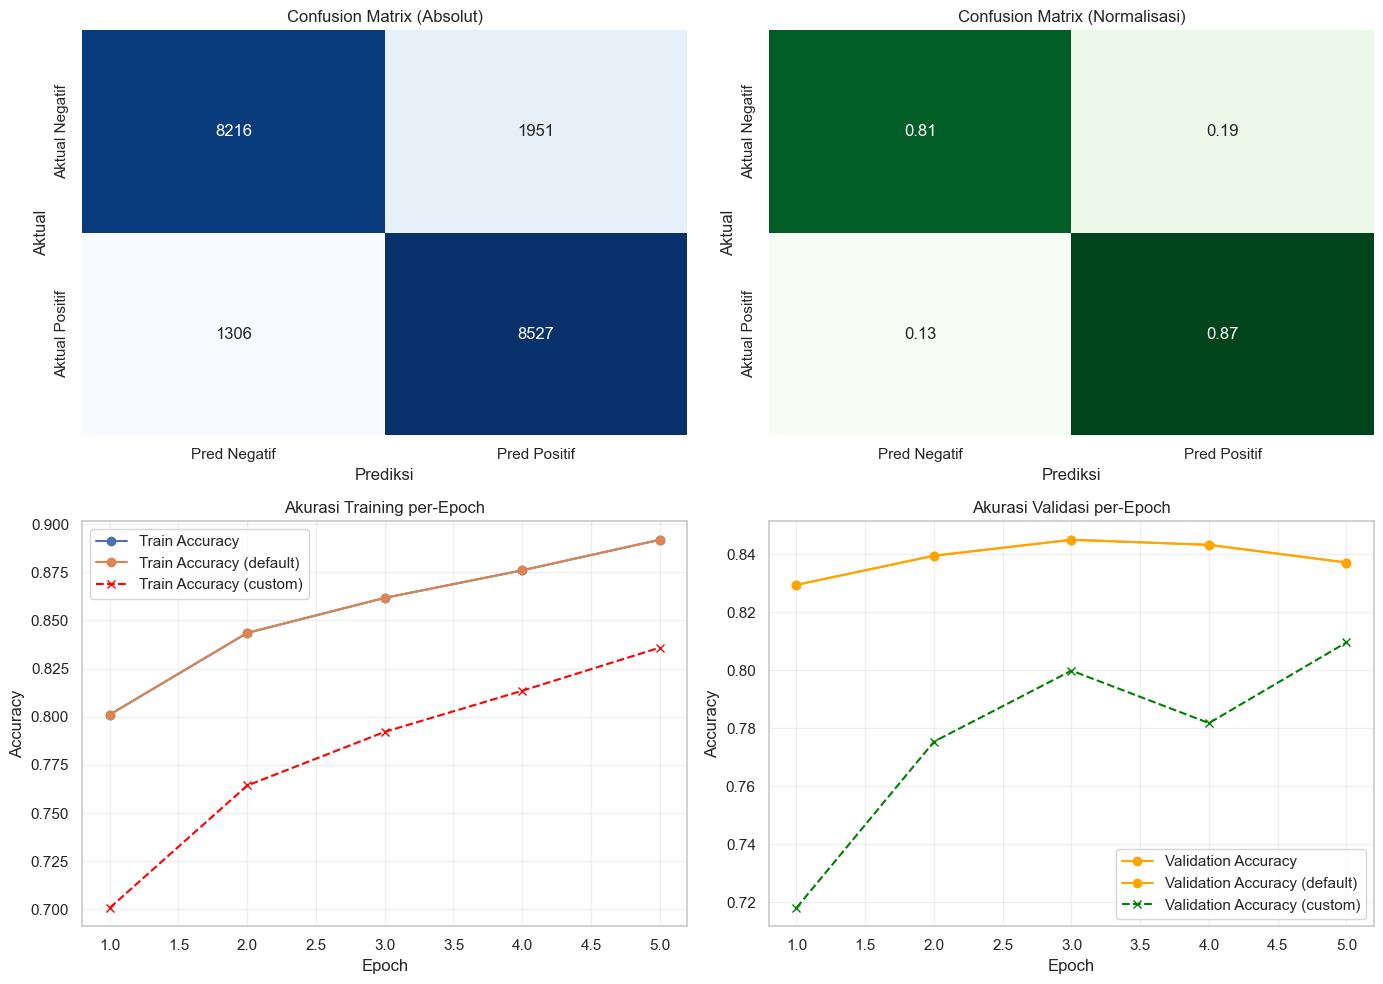

              precision    recall  f1-score   support

     Negatif       0.86      0.81      0.83     10167
     Positif       0.81      0.87      0.84      9833

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000


=== Rata-rata Score Prediksi per Label ===
      Label  Average Score
Negatif (0)       0.245577
Positif (1)       0.825830
  Rata-rata       0.530858


In [51]:
# Prediksi probabilitas dan label pada data uji
y_prob = model.predict(x_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Siapkan figure 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1,1) Absolut
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Negatif', 'Pred Positif'],
            yticklabels=['Aktual Negatif', 'Aktual Positif'], ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix (Absolut)')
axes[0, 0].set_xlabel('Prediksi')
axes[0, 0].set_ylabel('Aktual')

# (1,2) Normalisasi baris
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False,
            xticklabels=['Pred Negatif', 'Pred Positif'],
            yticklabels=['Aktual Negatif', 'Aktual Positif'], ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix (Normalisasi)')
axes[0, 1].set_xlabel('Prediksi')
axes[0, 1].set_ylabel('Aktual')

# Ambil akurasi dari history
hist = history.history if 'history' in globals() else {}
train_acc = hist.get('accuracy') or hist.get('acc')
val_acc = hist.get('val_accuracy') or hist.get('val_acc')
loss  = hist.get('loss') or hist.get('loss')
metric = hist.get('metric') or hist.get('met')
val_metric = hist.get('val_metric') or hist.get('val_met')
epochs_range = range(1, len(train_acc) + 1) if train_acc else []

# (2,1) Plot akurasi training per-epoch
axes[1, 0].plot(epochs_range, train_acc, marker='o', label='Train Accuracy') if train_acc else None
axes[1, 0].set_title('Akurasi Training per-Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend() if train_acc else None

# (2,2) Plot akurasi validasi per-epoch
axes[1, 1].plot(epochs_range, val_acc, marker='o', color='orange', label='Validation Accuracy') if val_acc else None
axes[1, 1].set_title('Akurasi Validasi per-Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend() if val_acc else None

# (2,1) Plot akurasi training per-epoch
axes[1, 0].plot(epochs_range, train_acc, marker='o', label='Train Accuracy (default)') if train_acc else None
axes[1, 0].plot(epochs_range, metric, marker='x', linestyle='--', color='red', label='Train Accuracy (custom)') if metric else None
axes[1, 0].set_title('Akurasi Training per-Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# (2,2) Plot akurasi validasi per-epoch
axes[1, 1].plot(epochs_range, val_acc, marker='o', color='orange', label='Validation Accuracy (default)') if val_acc else None
axes[1, 1].plot(epochs_range, val_metric, marker='x', linestyle='--', color='green', label='Validation Accuracy (custom)') if val_metric else None
axes[1, 1].set_title('Akurasi Validasi per-Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()


plt.tight_layout()
plt.show()

# Laporan klasifikasi untuk metrik tambahan
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Positif']))

# =========================
# Tambahan: Akurasi per label
# =========================
df_scores = pd.DataFrame({
    "y_true": y_test.ravel().astype(int),
    "y_prob": y_prob
})

# Hitung rata-rata score per label
avg_scores = df_scores.groupby("y_true")["y_prob"].mean().reset_index()
avg_scores["Label"] = avg_scores["y_true"].map({0: "Negatif (0)", 1: "Positif (1)"})
avg_scores = avg_scores[["Label", "y_prob"]].rename(columns={"y_prob": "Average Score"})

# Tambahkan rata-rata keseluruhan
overall_avg = pd.DataFrame([{"Label": "Rata-rata", "Average Score": df_scores["y_prob"].mean()}])
avg_scores = pd.concat([avg_scores, overall_avg], ignore_index=True)

print("\n=== Rata-rata Score Prediksi per Label ===")
print(avg_scores.to_string(index=False))

nanti yang ini tolong di implement fungsi buat cleaning data sama balancing data.

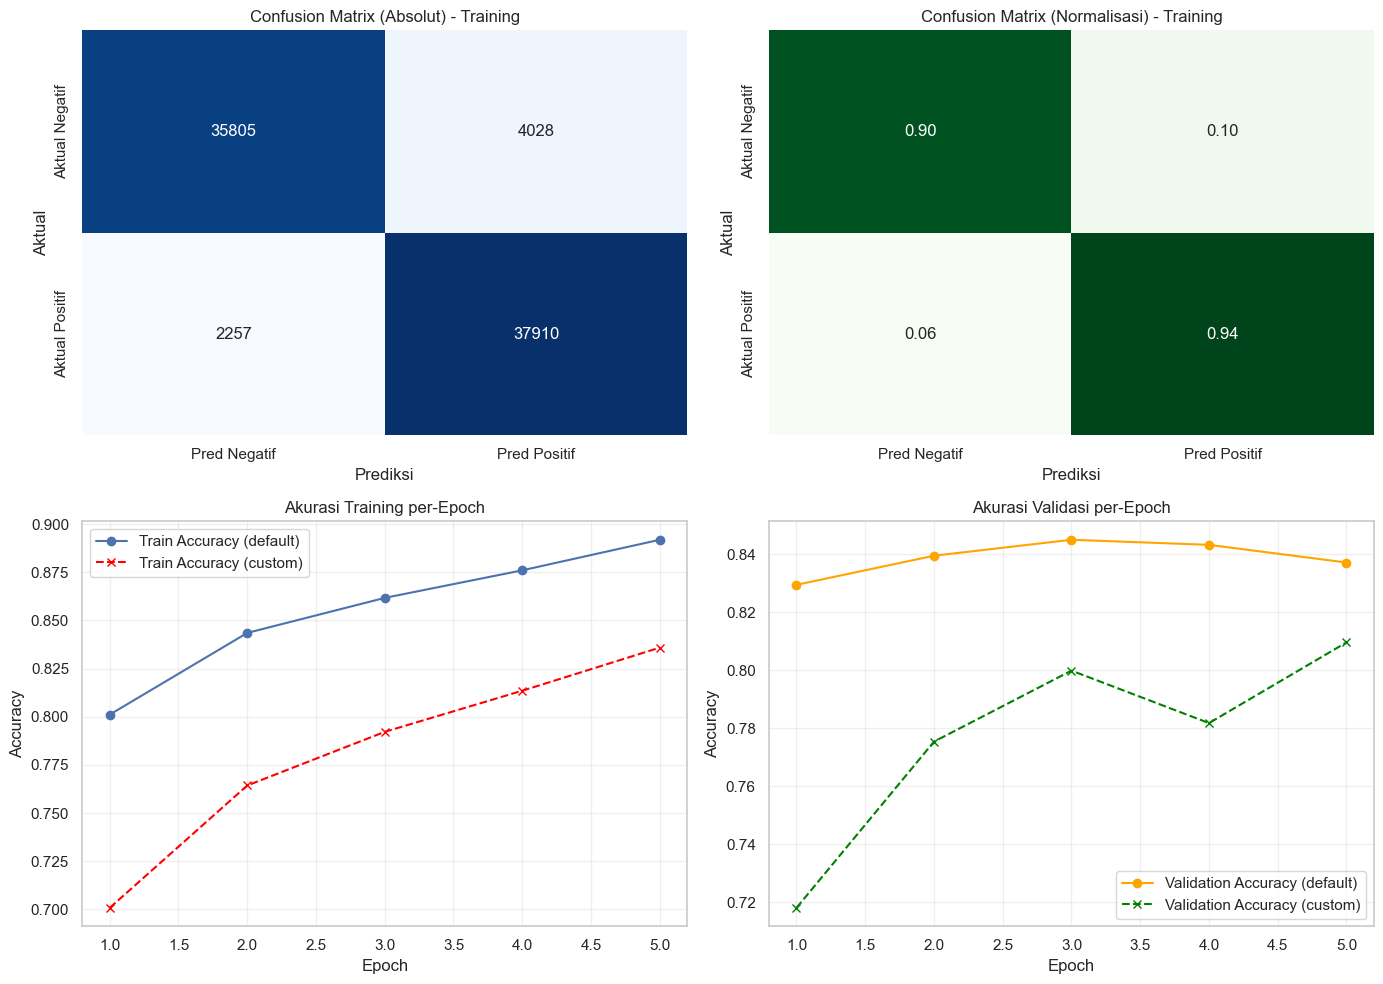

              precision    recall  f1-score   support

     Negatif       0.94      0.90      0.92     39833
     Positif       0.90      0.94      0.92     40167

    accuracy                           0.92     80000
   macro avg       0.92      0.92      0.92     80000
weighted avg       0.92      0.92      0.92     80000


=== Rata-rata Score Prediksi per Label (Training) ===
      Label  Average Score
Negatif (0)       0.180583
Positif (1)       0.884558
  Rata-rata       0.534040


In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prediksi probabilitas dan label pada data TRAINING
y_prob_train = model.predict(x_train, verbose=0).ravel()
y_pred_train = (y_prob_train >= 0.5).astype(int)

# Hitung confusion matrix
cm = confusion_matrix(y_train, y_pred_train, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Siapkan figure 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1,1) Confusion Matrix Absolut
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Negatif', 'Pred Positif'],
            yticklabels=['Aktual Negatif', 'Aktual Positif'], ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix (Absolut) - Training')
axes[0, 0].set_xlabel('Prediksi')
axes[0, 0].set_ylabel('Aktual')

# (1,2) Confusion Matrix Normalisasi
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False,
            xticklabels=['Pred Negatif', 'Pred Positif'],
            yticklabels=['Aktual Negatif', 'Aktual Positif'], ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix (Normalisasi) - Training')
axes[0, 1].set_xlabel('Prediksi')
axes[0, 1].set_ylabel('Aktual')

# Ambil akurasi dari history
hist = history.history if 'history' in globals() else {}
train_acc = hist.get('accuracy') or hist.get('acc')
val_acc = hist.get('val_accuracy') or hist.get('val_acc')
loss  = hist.get('loss') or hist.get('loss')
metric = hist.get('metric') or hist.get('met')
val_metric = hist.get('val_metric') or hist.get('val_met')
epochs_range = range(1, len(train_acc) + 1) if train_acc else []

# (2,1) Plot akurasi training per-epoch
axes[1, 0].plot(epochs_range, train_acc, marker='o', label='Train Accuracy (default)') if train_acc else None
axes[1, 0].plot(epochs_range, metric, marker='x', linestyle='--', color='red', label='Train Accuracy (custom)') if metric else None
axes[1, 0].set_title('Akurasi Training per-Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# (2,2) Plot akurasi validasi per-epoch
axes[1, 1].plot(epochs_range, val_acc, marker='o', color='orange', label='Validation Accuracy (default)') if val_acc else None
axes[1, 1].plot(epochs_range, val_metric, marker='x', linestyle='--', color='green', label='Validation Accuracy (custom)') if val_metric else None
axes[1, 1].set_title('Akurasi Validasi per-Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Laporan klasifikasi untuk data TRAINING
print(classification_report(y_train, y_pred_train, target_names=['Negatif', 'Positif']))

# =========================
# Tambahan: Rata-rata Score Prediksi per Label - Training
# =========================
df_scores = pd.DataFrame({
    "y_true": y_train.ravel().astype(int),
    "y_prob": y_prob_train
})

# Hitung rata-rata score per label
avg_scores = df_scores.groupby("y_true")["y_prob"].mean().reset_index()
avg_scores["Label"] = avg_scores["y_true"].map({0: "Negatif (0)", 1: "Positif (1)"})
avg_scores = avg_scores[["Label", "y_prob"]].rename(columns={"y_prob": "Average Score"})

# Tambahkan rata-rata keseluruhan
overall_avg = pd.DataFrame([{"Label": "Rata-rata", "Average Score": df_scores["y_prob"].mean()}])
avg_scores = pd.concat([avg_scores, overall_avg], ignore_index=True)

print("\n=== Rata-rata Score Prediksi per Label (Training) ===")
print(avg_scores.to_string(index=False))


In [53]:
model.save("sentiment_analysis_model.h5")

Jumlah data setelah sampling seimbang:
label
0    10000
1    10000
Name: count, dtype: int64

=== Evaluasi Threshold 0.5 (default) ===
Accuracy : 0.825
Precision: 0.857
Recall   : 0.780
F1-score : 0.817

=== Evaluasi Threshold 0.75 (custom) ===
Accuracy : 0.797
Precision: 0.931
Recall   : 0.642
F1-score : 0.760

=== Threshold terbaik berdasarkan F1 ===
Threshold: 0.30
Accuracy : 0.821
Precision: 0.791
Recall   : 0.873
F1-score : 0.830


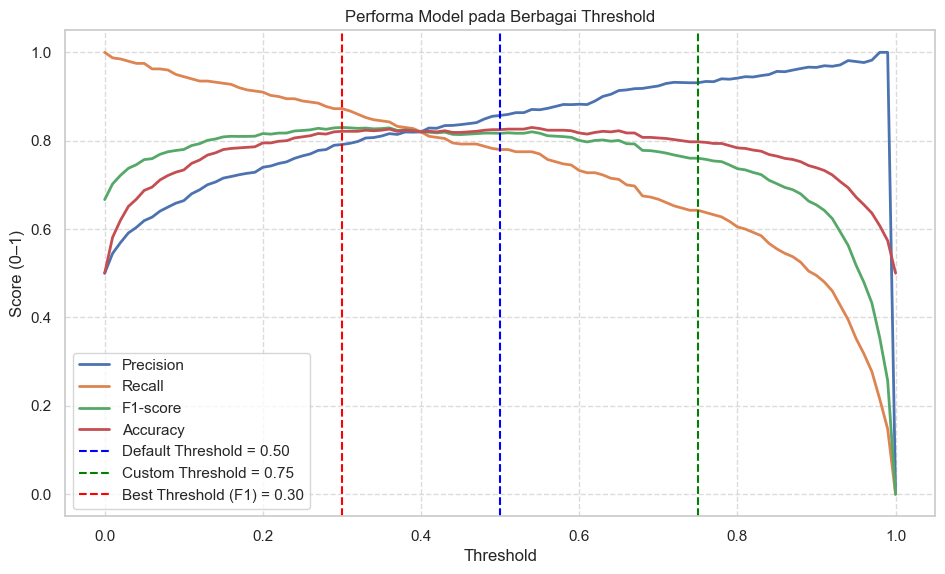

,review,rating,score,prediksi,actual,confusion
0,These are VERY dangerous for your dog. When e...,1,0.648489,negative,negative,TN
1,What's the best thing for a pregnant woman? Cr...,5,0.998940,positive,positive,TP
2,"Although I carefully followed the directions, ...",2,0.001422,negative,negative,TN
3,The boys love it! When they are driving me cr...,5,0.982371,positive,positive,TP
4,Misleading description of product. Wrong pictu...,1,0.013486,negative,negative,TN
5,You know after reading the other review I was ...,5,0.984441,positive,positive,TP
6,"This ""Baby White"" popcorn pops small and somew...",1,0.090848,negative,negative,TN
7,For anyone who needs to send a gift to someone...,5,0.813580,positive,positive,TP
8,I was hesitant of buying this product since th...,1,0.001744,negative,negative,TN
9,I would love to review it but I have not recei...,1,0.046209,negative,negative,TN



Ringkasan jumlah per kategori confusion:
confusion
TN    381
TP    257
FN    143
FP     19


,text,clean,score,prediksi
0,I love this product! It tastes amazing and I w...,love product taste amazing order,0.981921,positive
1,The packaging was terrible and half of the pro...,packaging terrible half product spilled,0.009138,negative
2,"Best purchase I have made, excellent flavor an...",best purchase made excellent flavor quality,0.990534,positive
3,"Very disappointed, I expected much better for ...",disappointed expected much better price,0.115520,negative
4,The texture was strange and I couldn’t finish it.,texture strange finish,0.032126,negative
...,...,...,...,...
94,"Absolutely loved it, can’t wait to order again.",absolutely loved wait order,0.995043,positive
95,"Couldn’t finish it, very disappointing.",finish disappointing,0.005452,negative
96,"It’s decent, but I’ve had better.",decent better,0.349186,negative
97,"The flavor is bold and unique, I love it.",flavor bold unique love,0.966214,positive


In [54]:
# ==== Testing otomatis dengan Reviews.csv + 20% validation + prediksi manual ====
# ====== Konfigurasi ======
THRESH = 0.75
LABEL_TEXT = {0: "negative", 1: "positive"}
MAX_SAMPLES_PER_LABEL = 10000  # contoh, sesuaikan dengan kebutuhan
# ====== Ambil referensi tokenizer dan panjang urutan ======
try:
    tok_ = tok
except NameError:
    tok_ = tokenizer
try:
    max_len = max_rev_len
except NameError:
    try:
        max_len = max_review_length
    except NameError:
        max_len = int(getattr(model.input_shape, "__getitem__", lambda x: [None, 256])[1])
# ====== Load ulang Reviews.csv ======
df = pd.read_csv("Reviews.csv", usecols=["Text", "Score"])
# Hanya rating 1–5 dan hapus missing
df = df[df["Score"].between(1, 5)].dropna()
# Hapus duplikat berdasarkan kolom Text dan Score
df = df.drop_duplicates(subset=["Text", "Score"]).reset_index(drop=True)
# Binerisasi label
df["label"] = (df["Score"] >= 3).astype(int)
# Bersihkan teks
df["clean_text"] = df["Text"].apply(clean_reviews)
# ====== Sampling seimbang per label ======
balanced_df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=min(MAX_SAMPLES_PER_LABEL, len(x)), random_state=42))
      .reset_index(drop=True)
)
print("Jumlah data setelah sampling seimbang:")
print(balanced_df["label"].value_counts())
# ====== Split train/val ======
X_train, X_val, y_train, y_val = train_test_split(
    balanced_df[["Text", "Score"]], balanced_df["label"],   # <== ambil Text + Score
    test_size=0.2, random_state=123, stratify=balanced_df["label"]
)
# ====== Ambil 20% subset dari validation set ======
X_eval, _, y_eval, _ = train_test_split(
    X_val, y_val, test_size=0.80, random_state=123, stratify=y_val
)
# ====== Tokenisasi & padding ======
seqs = tok_.texts_to_sequences(X_eval["Text"])
pad_eval = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")
# ====== Prediksi ======
y_prob = model.predict(pad_eval, verbose=0).ravel()
# ====== Evaluasi threshold default (0.5) dan custom (0.75) ======
y_pred_default = (y_prob >= 0.5).astype(int)
y_pred_custom  = (y_prob >= THRESH).astype(int)
print("\n=== Evaluasi Threshold 0.5 (default) ===")
print(f"Accuracy : {accuracy_score(y_eval, y_pred_default):.3f}")
print(f"Precision: {precision_score(y_eval, y_pred_default, zero_division=0):.3f}")
print(f"Recall   : {recall_score(y_eval, y_pred_default):.3f}")
print(f"F1-score : {f1_score(y_eval, y_pred_default):.3f}")
print("\n=== Evaluasi Threshold 0.75 (custom) ===")
print(f"Accuracy : {accuracy_score(y_eval, y_pred_custom):.3f}")
print(f"Precision: {precision_score(y_eval, y_pred_custom, zero_division=0):.3f}")
print(f"Recall   : {recall_score(y_eval, y_pred_custom):.3f}")
print(f"F1-score : {f1_score(y_eval, y_pred_custom):.3f}")
# ====== Analisis threshold grid search (0.0–1.0) ======
thresholds = np.linspace(0, 1, 101)
precisions, recalls, f1s, accs = [], [], [], []
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_eval, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_eval, y_pred_t))
    f1s.append(f1_score(y_eval, y_pred_t))
    accs.append(accuracy_score(y_eval, y_pred_t))
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
print(f"\n=== Threshold terbaik berdasarkan F1 ===")
print(f"Threshold: {best_thresh:.2f}")
print(f"Accuracy : {accs[best_idx]:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall   : {recalls[best_idx]:.3f}")
print(f"F1-score : {f1s[best_idx]:.3f}")
# ====== Plot metrik vs threshold ======
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, recalls, label="Recall", linewidth=2)
plt.plot(thresholds, f1s, label="F1-score", linewidth=2)
plt.plot(thresholds, accs, label="Accuracy", linewidth=2)
plt.axvline(0.5, color="blue", linestyle="--", label="Default Threshold = 0.50")
plt.axvline(THRESH, color="green", linestyle="--", label=f"Custom Threshold = {THRESH}")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best Threshold (F1) = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score (0–1)")
plt.title("Performa Model pada Berbagai Threshold")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
# ====== Konversi ke teks ======
pred_text = [LABEL_TEXT[p] for p in y_pred_custom]
act_text  = [LABEL_TEXT[a] for a in y_eval]
def confusion_type(p, a):
    if p == 1 and a == 1: return "TP"
    if p == 0 and a == 0: return "TN"
    if p == 1 and a == 0: return "FP"
    return "FN"
verdict = [confusion_type(p, a) for p, a in zip(y_pred_custom, y_eval)]
results_df = pd.DataFrame({
    "review": X_eval["Text"].values,
    "rating": X_eval["Score"].values,
    "score": y_prob,
    "prediksi": pred_text,
    "actual": act_text,
    "confusion": verdict
})
display(results_df.head(20))
print("\nRingkasan jumlah per kategori confusion:")
print(results_df["confusion"].value_counts().to_string())
# ====== Fungsi prediksi manual ======
def predict_manual(texts, threshold=THRESH):
    if isinstance(texts, str):
        texts = [texts]
    cleaned = [clean_reviews(t) for t in texts]
    seq = tok_.texts_to_sequences(cleaned)
    pad = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
    probs = model.predict(pad, verbose=0).ravel()
    preds = (probs >= threshold).astype(int)
    return pd.DataFrame({
        "text": texts,
        "clean": cleaned,
        "score": probs,
        "prediksi": [LABEL_TEXT[int(p)] for p in preds]
    })
predict_manual([
    # === contoh dari dataset + manual (total ~100) ===
    "I love this product! It tastes amazing and I will order it again.",
    "The packaging was terrible and half of the product was spilled.",
    "Best purchase I have made, excellent flavor and quality.",
    "Very disappointed, I expected much better for the price.",
    "The texture was strange and I couldn’t finish it.",
    "Perfect snack for my kids, they really enjoyed it.",
    "I will never buy this again, total waste of money.",
    "Great product, arrived fresh and delicious.",
    "Not bad, but not as good as I hoped.",
    "The cookies were stale and had no flavor.",
    "Outstanding product, exceeded my expectations.",
    "Really awful taste, threw it in the trash.",
    "Highly recommend, this is my new favorite brand.",
    "Mediocre at best, wouldn’t recommend to friends.",
    "Fresh, crispy, and very tasty.",
    "Terrible customer service and poor product quality.",
    "Absolutely loved it, will stock up on this.",
    "Too salty and unhealthy, not worth it.",
    "Perfect balance of flavor and price.",
    "Extremely disappointed, tasted like cardboard.",
    "It was okay, nothing special.",
    "The tea was very soothing and delicious.",
    "Worst coffee I’ve ever had.",
    "My whole family enjoyed this snack.",
    "Cheaply made and bland.",
    "The chocolate was smooth and rich.",
    "Mold inside the package, disgusting!",
    "Arrived quickly and tasted fresh.",
    "Horrible aftertaste, couldn’t eat more than one bite.",
    "This is the best granola I’ve ever tried.",
    "The pasta was broken and unusable.",
    "Fantastic quality, I’m very satisfied.",
    "Not fresh, expired taste.",
    "Delicious and healthy, perfect for my diet.",
    "Way too sweet, almost inedible.",
    "Very authentic flavor, reminds me of home.",
    "Bad smell and tasted spoiled.",
    "Five stars, will purchase again soon.",
    "Poorly packaged, lots of crumbs inside.",
    "Delightful taste and good portion size.",
    "Did not meet my expectations at all.",
    "Yummy! My kids loved it.",
    "Awful, very disappointed with this brand.",
    "Great value for the price.",
    "Tasted old and unpleasant.",
    "Crispy, fresh, and perfect for snacking.",
    "Wouldn’t buy again, tasted artificial.",
    "Excellent quality, worth every penny.",
    "Terrible experience, product arrived damaged.",
    "Simply amazing, loved every bite.",
    # --- Manual tambahan ---
    "the product was terrible, I want my money back",
    "amazing quality, will definitely buy again",
    "so-so, not too bad but not great either",
    ":unamused::unamused:",
    "This snack makes me happy every morning!",
    "I regret buying this, totally not worth it.",
    "Hands down the best product I have purchased online.",
    "My order arrived late and the box was crushed.",
    "Taste was fine, but portion size is too small.",
    "Surprisingly delicious, I didn’t expect much.",
    "I hate the flavor, very chemical taste.",
    "The texture is perfect, crunchy and fresh.",
    "Disappointing purchase, won’t repeat again.",
    "Absolutely fantastic, exceeded my expectations.",
    "Not recommended, flavorless and boring.",
    "My kids keep asking for more, they love it!",
    "Disgusting smell when I opened the bag.",
    "One of the best purchases I have made this year.",
    "Cheap quality product, very disappointed.",
    "Honestly, I’ve had better for half the price.",
    "I enjoyed every single bite of this snack.",
    "Worst packaging ever, completely unacceptable.",
    "The taste is average, nothing to complain about.",
    "Really good, I’ll buy this again soon.",
    "Too bitter for my liking.",
    "So yummy, I ate the whole bag in one sitting.",
    "Bad product, I feel scammed.",
    "The best snack to pair with coffee.",
    "Terrible, I wouldn’t feed this to my dog.",
    "Tastes homemade and very fresh.",
    "Lacked flavor, I was expecting more.",
    "Absolutely delicious, my friends loved it too.",
    "Total waste of money, don’t buy this.",
    "Surprisingly tasty, exceeded my expectations.",
    "Too oily and greasy for me.",
    "Perfectly seasoned, I really enjoyed it.",
    "Wouldn’t recommend, bad aftertaste.",
    "Fantastic! Will definitely reorder soon.",
    "Not good, the flavor is very artificial.",
    "This made me smile, such a good product!",
    "Worst taste ever, I regret buying this.",
    "Flavor was bland but texture was nice.",
    "My favorite snack now, 5 stars.",
    "Awful, tasted like chemicals.",
    "Absolutely loved it, can’t wait to order again.",
    "Couldn’t finish it, very disappointing.",
    "It’s decent, but I’ve had better.",
    "The flavor is bold and unique, I love it.",
    "Super salty, not enjoyable at all."
])

TESTING MANUAL DENGAN FUNCTION

In [55]:
# def predict_manual(texts, threshold=THRESH):
#     if isinstance(texts, str):
#         texts = [texts]
#     cleaned = [clean_reviews(t) for t in texts]
#     seq = tok_.texts_to_sequences(cleaned)
#     pad = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
#     probs = model.predict(pad, verbose=0).ravel()
#     preds = (probs >= threshold).astype(int)
#     return pd.DataFrame({
#         "text": texts,
#         "clean": cleaned,
#         "score": probs,
#         "prediksi": [LABEL_TEXT[int(p)] for p in preds]
#     })

# predict_manual([])

TESTING THE MODEL

Jumlah data setelah sampling seimbang:
label
0    10000
1    10000
Name: count, dtype: int64

=== Evaluasi Threshold 0.50 ===
Accuracy : 0.825
Precision: 0.857
Recall   : 0.780
F1-score : 0.817

=== Evaluasi Threshold 0.75 ===
Accuracy : 0.797
Precision: 0.931
Recall   : 0.642
F1-score : 0.760

=== Threshold terbaik berdasarkan F1 (subset eval) ===
Threshold: 0.30
Accuracy : 0.821
Precision: 0.791
Recall   : 0.873
F1-score : 0.830


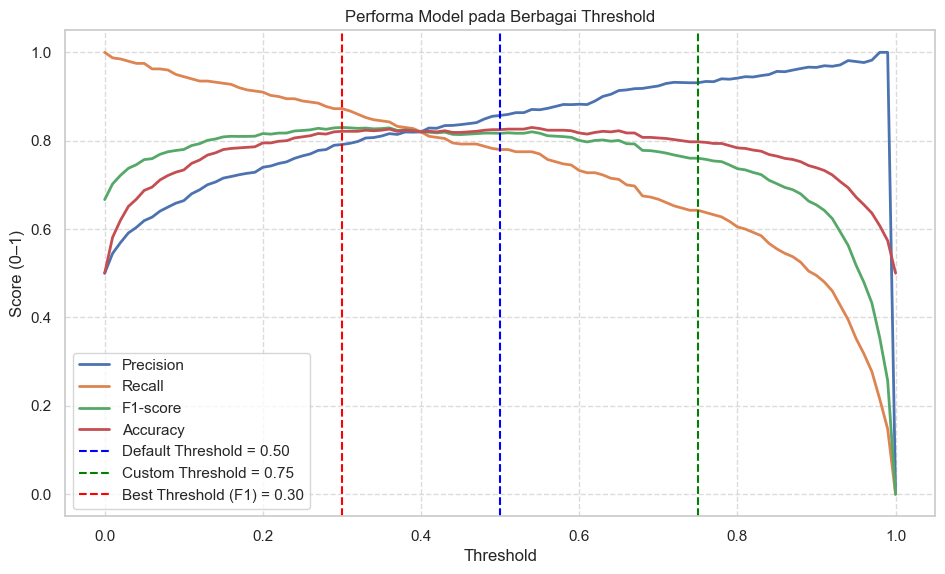


=== Threshold berbasis rata-rata skor per label ===
Rata-rata skor negatif = 0.188
Rata-rata skor positif = 0.753
Threshold (midpoint)   = 0.471
Accuracy  = 0.813
Precision = 0.972
Recall    = 0.805
F1-score  = 0.881


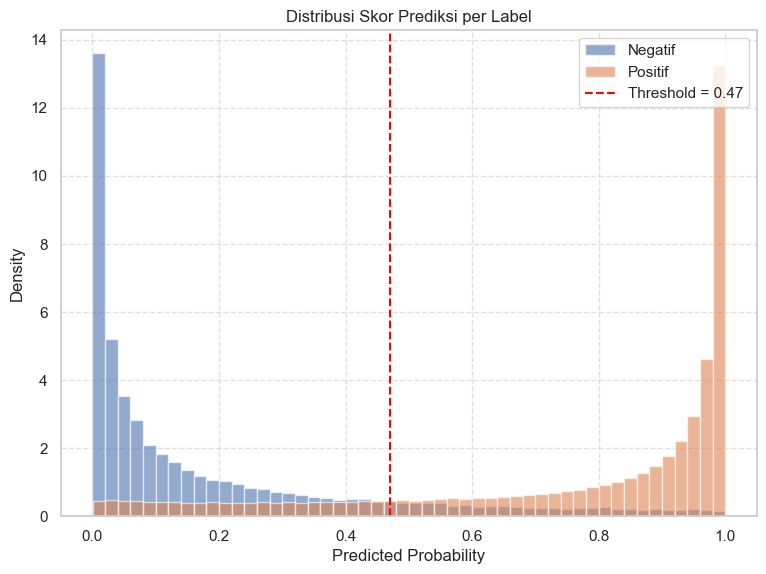

In [60]:
# ====== IMPORT LIBRARY ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# ====== KONFIGURASI ======
THRESH = 0.75
LABEL_TEXT = {0: "negative", 1: "positive"}
MAX_SAMPLES_PER_LABEL = 10000  # contoh limit, bisa diperbesar

# asumsikan variabel tok/tokenizer & fungsi clean_reviews sudah ada
try:
    tok_ = tok
except NameError:
    tok_ = tokenizer

try:
    max_len = max_rev_len
except NameError:
    try:
        max_len = max_review_length
    except NameError:
        max_len = 256  # fallback default

# ====== LOAD DATASET ======
df = pd.read_csv("Reviews.csv", usecols=["Text", "Score"])
df = df[df["Score"].between(1, 5)].dropna()
df = df.drop_duplicates(subset=["Text", "Score"]).reset_index(drop=True)

# ====== LABEL BINER ======
df["label"] = (df["Score"] >= 3).astype(int)
df["review"] = df["Text"]

# ====== CLEANING TEKS ======
df["clean_text"] = df["Text"].apply(clean_reviews)

# ====== SAMPLING SEIMBANG PER LABEL ======
balanced_df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=min(MAX_SAMPLES_PER_LABEL, len(x)), random_state=42))
      .reset_index(drop=True)
)

print("Jumlah data setelah sampling seimbang:")
print(balanced_df["label"].value_counts())

# ====== SPLIT TRAIN/VALIDASI ======
X_train, X_val, y_train, y_val = train_test_split(
    balanced_df[["Text", "Score"]],
    balanced_df["label"],
    test_size=0.2,
    random_state=123,
    stratify=balanced_df["label"]
)

# ====== AMBIL 20% VALIDATION SEBAGAI EVALUASI ======
X_eval, _, y_eval, _ = train_test_split(
    X_val, y_val,
    test_size=0.80,
    random_state=123,
    stratify=y_val
)

# ====== TOKENISASI & PADDING ======
seqs = tok_.texts_to_sequences(X_eval["Text"])
pad_eval = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")

# ====== PREDIKSI MODEL ======
y_prob = model.predict(pad_eval, verbose=0).ravel()

# ====== EVALUASI THRESHOLD DEFAULT DAN CUSTOM ======
for t in [0.5, THRESH]:
    y_pred = (y_prob >= t).astype(int)
    print(f"\n=== Evaluasi Threshold {t:.2f} ===")
    print(f"Accuracy : {accuracy_score(y_eval, y_pred):.3f}")
    print(f"Precision: {precision_score(y_eval, y_pred, zero_division=0):.3f}")
    print(f"Recall   : {recall_score(y_eval, y_pred):.3f}")
    print(f"F1-score : {f1_score(y_eval, y_pred):.3f}")

# ====== GRID SEARCH THRESHOLD (0–1) ======
thresholds = np.linspace(0, 1, 101)
precisions, recalls, f1s, accs = [], [], [], []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_eval, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_eval, y_pred_t))
    f1s.append(f1_score(y_eval, y_pred_t))
    accs.append(accuracy_score(y_eval, y_pred_t))

best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]

print(f"\n=== Threshold terbaik berdasarkan F1 (subset eval) ===")
print(f"Threshold: {best_thresh:.2f}")
print(f"Accuracy : {accs[best_idx]:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall   : {recalls[best_idx]:.3f}")
print(f"F1-score : {f1s[best_idx]:.3f}")

# ====== PLOT KURVA METRIK ======
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, recalls, label="Recall", linewidth=2)
plt.plot(thresholds, f1s, label="F1-score", linewidth=2)
plt.plot(thresholds, accs, label="Accuracy", linewidth=2)
plt.axvline(0.5, color="blue", linestyle="--", label="Default Threshold = 0.50")
plt.axvline(THRESH, color="green", linestyle="--", label=f"Custom Threshold = {THRESH}")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best Threshold (F1) = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score (0–1)")
plt.title("Performa Model pada Berbagai Threshold")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# ====== ANALISIS SELURUH DATA ======
seqs_all = tok_.texts_to_sequences(df["review"])
pad_all = pad_sequences(seqs_all, maxlen=max_len, padding="post", truncating="post")
y_all_prob = model.predict(pad_all, verbose=0).ravel()
y_all_true = df["label"].values

thresholds_full = np.arange(0, 1.01, 0.1)
accuracies, precisions, recalls, f1s = [], [], [], []

for t in thresholds_full:
    y_pred_t = (y_all_prob >= t).astype(int)
    accuracies.append(accuracy_score(y_all_true, y_pred_t))
    precisions.append(precision_score(y_all_true, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_all_true, y_pred_t))
    f1s.append(f1_score(y_all_true, y_pred_t))

avg_neg = y_all_prob[y_all_true == 0].mean()
avg_pos = y_all_prob[y_all_true == 1].mean()
best_thresh_label = (avg_neg + avg_pos) / 2

y_pred_label = (y_all_prob >= best_thresh_label).astype(int)

print(f"\n=== Threshold berbasis rata-rata skor per label ===")
print(f"Rata-rata skor negatif = {avg_neg:.3f}")
print(f"Rata-rata skor positif = {avg_pos:.3f}")
print(f"Threshold (midpoint)   = {best_thresh_label:.3f}")
print(f"Accuracy  = {accuracy_score(y_all_true, y_pred_label):.3f}")
print(f"Precision = {precision_score(y_all_true, y_pred_label, zero_division=0):.3f}")
print(f"Recall    = {recall_score(y_all_true, y_pred_label):.3f}")
print(f"F1-score  = {f1_score(y_all_true, y_pred_label):.3f}")

# Plot distribusi prediksi per label
plt.figure(figsize=(8,6))
plt.hist(y_all_prob[y_all_true==0], bins=50, alpha=0.6, label="Negatif", density=True)
plt.hist(y_all_prob[y_all_true==1], bins=50, alpha=0.6, label="Positif", density=True)
plt.axvline(best_thresh_label, color="red", linestyle="--", label=f"Threshold = {best_thresh_label:.2f}")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Distribusi Skor Prediksi per Label")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ====== FUNGSI PREDIKSI MANUAL ======
def predict_manual(texts, threshold=THRESH):
    if isinstance(texts, str):
        texts = [texts]
    cleaned = [clean_reviews(t) for t in texts]
    seq = tok_.texts_to_sequences(cleaned)
    pad = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
    probs = model.predict(pad, verbose=0).ravel()
    preds = (probs >= threshold).astype(int)
    return pd.DataFrame({
        "text": texts,
        "clean": cleaned,
        "score": probs,
        "prediksi": [LABEL_TEXT[int(p)] for p in preds]
    })